In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn### machine learning library
import cv2
from sklearn.metrics import confusion_matrix, roc_curve### metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.keras.applications import VGG16
import warnings
warnings.filterwarnings('ignore')
print(tf.__version__)

2024-11-10 18:14:19.827603: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0


In [7]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 5.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
train_directory = "dataset/train"
val_directory = "dataset/test"

In [3]:
classes = ["angry", "disgusted","fearful","happy","neutral", "sad","surprised"]

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names= classes,
    color_mode='rgb',
    batch_size=32,
    image_size=(48, 48),
    shuffle=True,
    seed=99,
)

Found 28709 files belonging to 7 classes.


In [5]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names= classes,
    color_mode='rgb',
    batch_size=1,
    image_size=(48,48),
    shuffle=True,
    seed=99,
)

Found 7178 files belonging to 7 classes.


In [6]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [7]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [8]:
# Load VGG16 model pre-trained on ImageNet data, without top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

In [9]:
# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
predictions = Dense(7, activation='softmax')(x)  # Final output layer for 7 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
model.summary(_)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [11]:
loss_function = CategoricalCrossentropy()

In [12]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=4, name = "top_k_accuracy")]

In [13]:
model.compile(
  optimizer = Adam(learning_rate = 1e-3),
  loss = loss_function,
  metrics = metrics,
)

In [22]:
history = model.fit(
  training_dataset,
  validation_data = validation_dataset,
  batch_size= 32,

  epochs = 20,
  verbose = 1
)

Epoch 1/20
898/898 [==============================] - 1402s 2s/step - loss: 1.5582 - accuracy: 0.3761 - top_k_accuracy: 0.8435 - val_loss: 1.4657 - val_accuracy: 0.4218 - val_top_k_accuracy: 0.8742
Epoch 2/20
898/898 [==============================] - 1549s 2s/step - loss: 1.4368 - accuracy: 0.4262 - top_k_accuracy: 0.8791 - val_loss: 1.3596 - val_accuracy: 0.4737 - val_top_k_accuracy: 0.8950
Epoch 3/20
898/898 [==============================] - 1398s 2s/step - loss: 1.3468 - accuracy: 0.4756 - top_k_accuracy: 0.9053 - val_loss: 1.3332 - val_accuracy: 0.4939 - val_top_k_accuracy: 0.9054
Epoch 4/20
898/898 [==============================] - 1305s 1s/step - loss: 1.2809 - accuracy: 0.5053 - top_k_accuracy: 0.9187 - val_loss: 1.2706 - val_accuracy: 0.5156 - val_top_k_accuracy: 0.9185
Epoch 5/20
898/898 [==============================] - 1256s 1s/step - loss: 1.2397 - accuracy: 0.5260 - top_k_accuracy: 0.9263 - val_loss: 1.3792 - val_accuracy: 0.5219 - val_top_k_accuracy: 0.9184
Epoch 6/20

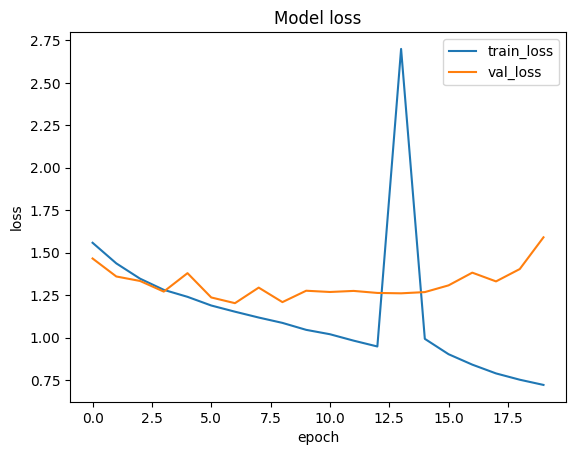

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

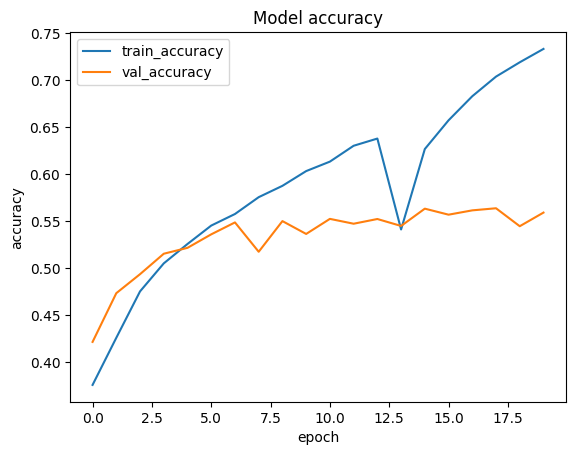

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [25]:
model.save('face_detection_model_vgg16.h5')

7178/7178 [==============================] - 135s 19ms/step


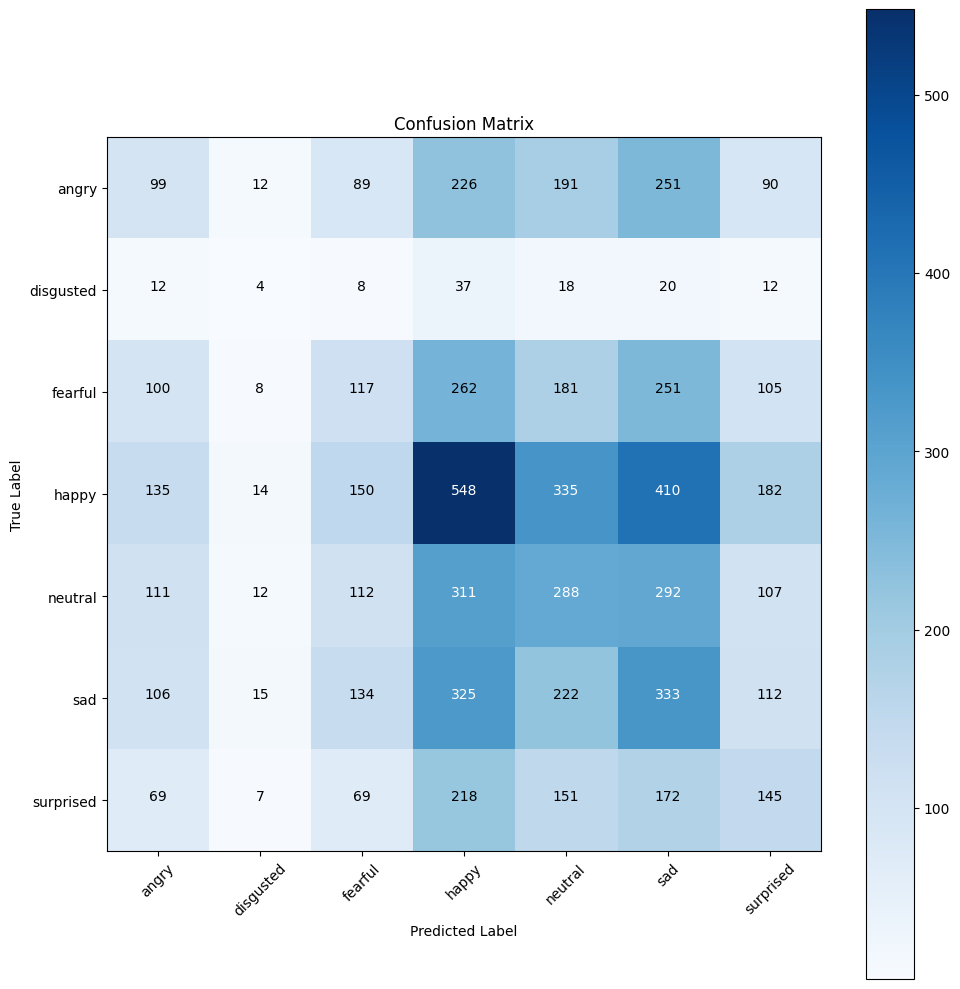

In [27]:
import itertools
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Get true labels from validation_dataset
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)
true_labels = np.argmax(true_labels, axis=1)  # Convert one-hot to label indices

# Predict using the model on validation_dataset
predictions = model.predict(validation_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
classes = ["angry", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"]

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations to the cells
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


<h1>Hasil evalusi confusion matrix</h1>

Observasi Utama
1. Ketidakseimbangan Kelas dalam Prediksi:
- Beberapa kelas (misalnya, "happy") memiliki jumlah prediksi yang jauh lebih banyak dibandingkan kelas lainnya. Hal ini menunjukkan bahwa model mungkin bias terhadap emosi tertentu. Ini terlihat dari sel biru gelap di baris dan kolom "happy," yang menunjukkan jumlah prediksi yang tinggi untuk kategori ini.
- Kelas seperti "disgusted" dan "surprised" tampaknya memiliki jumlah yang lebih rendah, yang bisa menunjukkan bahwa model kesulitan untuk memprediksi emosi ini secara akurat atau mungkin karena kelas tersebut kurang terwakili dalam dataset.
  
2. Sel Diagonal (True Positives):
- Sel diagonal merepresentasikan prediksi yang benar (true positives) untuk setiap kelas.
Sebagai contoh, "happy" memiliki jumlah true positives tertinggi (548), menunjukkan bahwa model dapat mengenali emosi ini relatif baik dibandingkan dengan emosi lainnya.
- Di sisi lain, "disgusted" memiliki true positives yang sangat sedikit (hanya 4), yang menunjukkan bahwa model mengalami kesulitan dalam mengenali emosi ini.

3. Sel di Luar Diagonal (Misclassifications):
- Banyak kesalahan klasifikasi (misclassifications) terjadi antara kelas-kelas yang memiliki fitur yang mirip.
  Contohnya:
"Happy" sering diklasifikasikan keliru sebagai "neutral" dan "sad," yang menunjukkan bahwa emosi ini mungkin memiliki kesamaan visual yang sulit dibedakan oleh model.
"Fearful" dan "sad" juga sering keliru dengan "angry" dan "neutral," yang bisa disebabkan oleh ekspresi wajah yang tumpang tindih antara emosi-emosi ini.
- Model cenderung mengklasifikasikan keliru antara "angry," "fearful," dan "sad," yang menunjukkan bahwa model mungkin memerlukan fitur yang lebih halus atau augmentasi data untuk membedakan perbedaan kecil di antara emosi-emosi ini.

4. Kebingungan dengan Kelas "Neutral":
- Terdapat banyak kesalahan klasifikasi ke dalam kategori "neutral" dari berbagai kelas, seperti "angry," "fearful," dan "sad."
- Hal ini dapat mengindikasikan bahwa model kesulitan membedakan ekspresi netral dari variasi kecil dalam ekspresi emosional, yang merupakan tantangan umum dalam klasifikasi emosi.

5. Saran untuk Peningkatan:
- Augmentasi Data: Menambahkan lebih banyak sampel untuk kelas yang kurang terwakili seperti "disgusted" dapat membantu model untuk belajar lebih baik tentang emosi tersebut.
- Penyeimbangan Kelas: Mengatur bobot kelas selama pelatihan atau menambahkan sampel sintetis dapat mengurangi bias terhadap kelas tertentu.
- Peningkatan Arsitektur Model: Menambahkan lapisan ekstraksi fitur yang lebih spesifik atau melakukan fine-tuning model pada jaringan yang telah dilatih sebelumnya dan khusus untuk ekspresi wajah mungkin dapat meningkatkan kinerja.
- Tuning Hyperparameter: Mencoba berbagai nilai learning rate, batch size, dan optimizer juga mungkin dapat memberikan perbaikan.

6. Evaluasi Lebih Lanjut:
- Akan lebih membantu jika melihat laporan klasifikasi untuk menilai precision, recall, dan F1 score untuk setiap kelas, karena metrik ini memberikan pemahaman yang lebih jelas tentang performa model selain dari akurasi.
  
Analisis ini menunjukkan bahwa walaupun model memiliki kinerja yang cukup baik untuk emosi "happy," model masih kesulitan membedakan beberapa emosi, terutama "disgusted" dan "neutral." Perbaikan dalam representasi data dan fine-tuning model mungkin dapat membantu mengurangi kesalahan klasifikasi ini.

In [29]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(true_labels, predicted_labels, target_names=classes))

              precision    recall  f1-score   support

       angry       0.16      0.10      0.12       958
   disgusted       0.06      0.04      0.04       111
     fearful       0.17      0.11      0.14      1024
       happy       0.28      0.31      0.30      1774
     neutral       0.21      0.23      0.22      1233
         sad       0.19      0.27      0.22      1247
   surprised       0.19      0.17      0.18       831

    accuracy                           0.21      7178
   macro avg       0.18      0.18      0.18      7178
weighted avg       0.21      0.21      0.21      7178



<h1>Evaluasi Report classification</h1>
Berdasarkan output laporan klasifikasi, berikut adalah analisis komprehensif terhadap kinerja model:

1. Performa Per Kelas (Precision, Recall, F1-Score)
- angry: Precision 0.16, Recall 0.10, F1-score 0.12
Model memiliki performa yang rendah dalam mendeteksi emosi "angry," yang ditunjukkan oleh nilai precision dan recall yang rendah. Model sering mengklasifikasikan gambar sebagai kelas lain saat seharusnya "angry."
- disgusted: Precision 0.06, Recall 0.04, F1-score 0.04
Performa untuk kelas "disgusted" sangat buruk, dengan precision, recall, dan F1-score di bawah 0.1. Hal ini menunjukkan bahwa model hampir tidak dapat mendeteksi emosi ini dengan benar. Ini bisa disebabkan oleh jumlah data yang sangat sedikit untuk kelas ini (hanya 111 sampel).
- fearful: Precision 0.17, Recall 0.11, F1-score 0.14
Kelas "fearful" memiliki performa yang rendah, namun sedikit lebih baik dibanding "angry" dan "disgusted." Nilai recall yang rendah menunjukkan bahwa banyak gambar "fearful" yang diklasifikasikan ke kelas lain.
- happy: Precision 0.28, Recall 0.31, F1-score 0.30
Kelas "happy" memiliki performa terbaik dibandingkan dengan kelas lain, dengan nilai precision, recall, dan F1-score yang lebih tinggi. Hal ini menunjukkan bahwa model lebih mampu mendeteksi emosi ini, meskipun kinerjanya masih bisa ditingkatkan.
- neutral: Precision 0.21, Recall 0.23, F1-score 0.22
Untuk kelas "neutral," model memiliki performa yang sedang. Nilai precision dan recall berada di sekitar 0.2, menunjukkan bahwa model masih mengalami kesulitan dalam membedakan ekspresi "neutral" dari emosi lainnya.
- sad: Precision 0.19, Recall 0.27, F1-score 0.22
Model memiliki kemampuan yang agak lebih baik dalam mendeteksi "sad" dibandingkan beberapa kelas lainnya, dengan recall 0.27. Namun, nilai precision yang rendah menunjukkan bahwa model sering salah dalam mengklasifikasikan kelas ini, mungkin sering terklasifikasi ke kelas yang mirip.
- surprised: Precision 0.19, Recall 0.17, F1-score 0.18
Kelas "surprised" memiliki performa yang serupa dengan beberapa kelas lain dengan precision dan recall yang rendah. Hal ini menunjukkan bahwa model sering mengalami kesalahan dalam mendeteksi emosi ini.

2. Keseluruhan Kinerja Model
- Accuracy: 0.21
Akurasi keseluruhan hanya 21%, yang menunjukkan bahwa model sering salah dalam mengklasifikasikan emosi. Ini adalah indikasi bahwa model memerlukan perbaikan signifikan untuk menjadi lebih andal dalam tugas klasifikasi emosi.
- Macro Average (Rata-rata Makro):
Precision 0.18, Recall 0.18, F1-score 0.18
Rata-rata makro (macro average) menunjukkan nilai rata-rata dari setiap metrik tanpa mempertimbangkan jumlah sampel per kelas. Dengan nilai precision, recall, dan F1-score yang serupa dan rendah, hal ini menunjukkan bahwa model memiliki performa yang buruk secara konsisten di semua kelas.
- Weighted Average (Rata-rata Berbobot):
Precision 0.21, Recall 0.21, F1-score 0.21
Rata-rata berbobot mempertimbangkan jumlah sampel per kelas. Hasil ini hampir sama dengan akurasi karena model cenderung lebih sering benar untuk kelas dengan lebih banyak data (seperti "happy"), tetapi tetap menunjukkan performa yang rendah secara keseluruhan.

3. Analisis Tambahan dan Saran Perbaikan
- Ketidakseimbangan Kelas:
Nilai recall dan precision yang rendah pada kelas "disgusted" menunjukkan ketidakseimbangan kelas yang signifikan. Kelas "disgusted" memiliki jumlah sampel yang jauh lebih sedikit daripada kelas lain, yang menyebabkan model kesulitan dalam mengenali emosi ini. Menambah data untuk kelas yang kurang terwakili atau menggunakan metode oversampling dapat membantu mengatasi masalah ini.
- Penggunaan Teknik Augmentasi Data:
Dengan menggunakan augmentasi data (seperti rotasi, skala, kontras, dan lainnya), model dapat dilatih untuk mengenali emosi dalam berbagai variasi ekspresi wajah. Ini dapat membantu model untuk lebih membedakan antar kelas yang sulit dibedakan.
- Fine-Tuning Model dan Arsitektur:
Mungkin perlu dilakukan fine-tuning pada model yang lebih canggih atau arsitektur yang lebih sesuai untuk pengenalan ekspresi wajah. Selain itu, mengganti atau menambahkan lapisan khusus untuk deteksi fitur wajah yang lebih halus bisa membantu meningkatkan akurasi.
- Pengaturan Hyperparameter:
Melakukan tuning hyperparameter, seperti learning rate, batch size, dan jumlah epoch, juga dapat memberikan peningkatan performa. Hyperparameter yang tepat dapat membantu model untuk lebih efektif belajar dari data.
- Pemilihan Model yang Lebih Tepat:
Mengingat bahwa klasifikasi emosi adalah tugas yang kompleks, menggunakan model yang lebih besar atau yang dilatih khusus untuk tugas serupa mungkin lebih efektif. Misalnya, arsitektur model seperti ResNet atau model yang sudah dilatih khusus untuk tugas klasifikasi wajah dapat dieksplorasi lebih lanjut.

<h3>Kesimpulan</h3>
Performa model ini masih rendah untuk sebagian besar kelas, dengan akurasi hanya 21%. Model lebih baik dalam mendeteksi emosi "happy" dibandingkan dengan yang lain, tetapi kesulitan dalam mengenali kelas seperti "disgusted" dan "angry." Saran utama untuk perbaikan termasuk menambah data untuk kelas yang kurang terwakili, menggunakan teknik augmentasi data, fine-tuning hyperparameter, dan mempertimbangkan arsitektur model yang lebih canggih atau khusus untuk klasifikasi ekspresi wajah.

<h1>Lakukan optimasi</h1> 

In [ ]:
import numpy as np
from sklearn.utils import class_weight

# Mendapatkan semua label dari train_dataset untuk menghitung class weights
all_labels = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in train_dataset], axis=0)

# Menggunakan class_weight dari sklearn untuk menghitung bobot kelas
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(classes)),
    y=all_labels
)

# Mengonversi class_weights ke format dictionary
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Melatih model dengan class_weights
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    batch_size=32,
    epochs=20,
    verbose=1,
    class_weight=class_weights  # Menyediakan class weights untuk melatih model
)

Class Weights: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}
Epoch 1/20
898/898 [==============================] - 1093s 1s/step - loss: 2.1764 - accuracy: 0.1202 - top_k_accuracy: 0.5812 - val_loss: 1.9468 - val_accuracy: 0.0155 - val_top_k_accuracy: 0.5790
Epoch 2/20
898/898 [==============================] - 1111s 1s/step - loss: 1.9463 - accuracy: 0.1146 - top_k_accuracy: 0.5623 - val_loss: 1.9457 - val_accuracy: 0.2471 - val_top_k_accuracy: 0.5790
Epoch 3/20
898/898 [==============================] - 1097s 1s/step - loss: 1.9463 - accuracy: 0.1225 - top_k_accuracy: 0.5768 - val_loss: 1.9460 - val_accuracy: 0.2471 - val_top_k_accuracy: 0.5790
Epoch 4/20
898/898 [==============================] - 1085s 1s/step - loss: 1.9462 - accuracy: 0.1304 - top_k_accuracy: 0.5690 - val_loss: 1.9458 - val_accuracy: 0.2471 - val_top_k_accuracy: 0.5790
Epoch 5/20
898/898 [=============

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Mendapatkan true labels dari validation_dataset
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)
true_labels = np.argmax(true_labels, axis=1)  # Konversi dari one-hot encoding ke indeks kelas

# Mendapatkan prediksi dari model
predictions = model.predict(validation_dataset)
predicted_labels = np.argmax(predictions, axis=1)  # Mengonversi prediksi ke indeks kelas

# Membuat confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
classes = ["angry", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"]

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Menambahkan teks pada setiap sel dalam confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Menampilkan laporan klasifikasi untuk metrik precision, recall, dan F1-score
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))